### Importing Libraries and Loading Data

In [0]:
# !pip install kaggle

# !mkdir .kaggle

# import json
# token = {"username":"ivyclare","key":"86f0e659c102ab797c73851bbad8373e"}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)

# !chmod 600 /content/.kaggle/kaggle.json

# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
 
 
# !kaggle config set -n path -v{/content}

# !kaggle datasets download -d shayanfazeli/heartbeat -p /content

# !unzip \*.zip

In [0]:
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split  
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


Using TensorFlow backend.


In [0]:
### Load Dataset
train_dataframe = pd.read_csv("mitbih_train.csv", header=None)
test_dataframe = pd.read_csv("mitbih_test.csv", header=None)
dataframe = pd.concat([train_dataframe,test_dataframe], axis=0)

### Exploring Data

In [0]:
#Method For Data Exporation

def exploreData(dataframe):
    # Preview dataset
    print("Dataset Head")
    print(dataframe.head(3))
    print("--" * 50)
    
    # Features in dataset
    print("Dataset Atrributes")
    print(dataframe.columns.values)
    print("--" * 50)
    
     # view distribution of numerical features across the data set
    print("Dataset Numerical Features")
    print(dataframe.describe())
    print("--" * 50)
    
    # View How many samples and how many missing values for each feature
    print("Dataset Features Details")
    print(dataframe.info())
    print("--" * 50)
    
    # view distribution of categorical features across the data set
#     print("Dataset Categorical Features")
#     print(dataframe.describe(include=['O']))
#     print("--" * 50)
        
    #Checking for missing values
    print("Check for Missing Values")
    print(dataframe.isnull().sum())
    print("--" * 50)

     #Get number of instances and number of attributes
    print("Number of Instances and Attributes")
    print(dataframe.shape)
    print("--" * 50)
    
exploreData(dataframe)
# Distribution of Output Variable
dataframe[187].value_counts()

Dataset Head
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   

        7         8         9   ...   178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  

[3 rows x 188 columns]
----------------------------------------------------------------------------------------------------
Dataset Atrributes
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  4

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

### Observations
- No missing values
- 109446 samples
- 188 attributes
- Dataset is unbalanced
Data was already filtered and beats extracted according to the paper **ECG Heartbeat Classification: A Deep Transferable
Representation**

In [0]:
M = dataframe.values
X = M[:, :-1]
y = M[:, -1].astype(int)

### Getting Data For Each Category

In [0]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

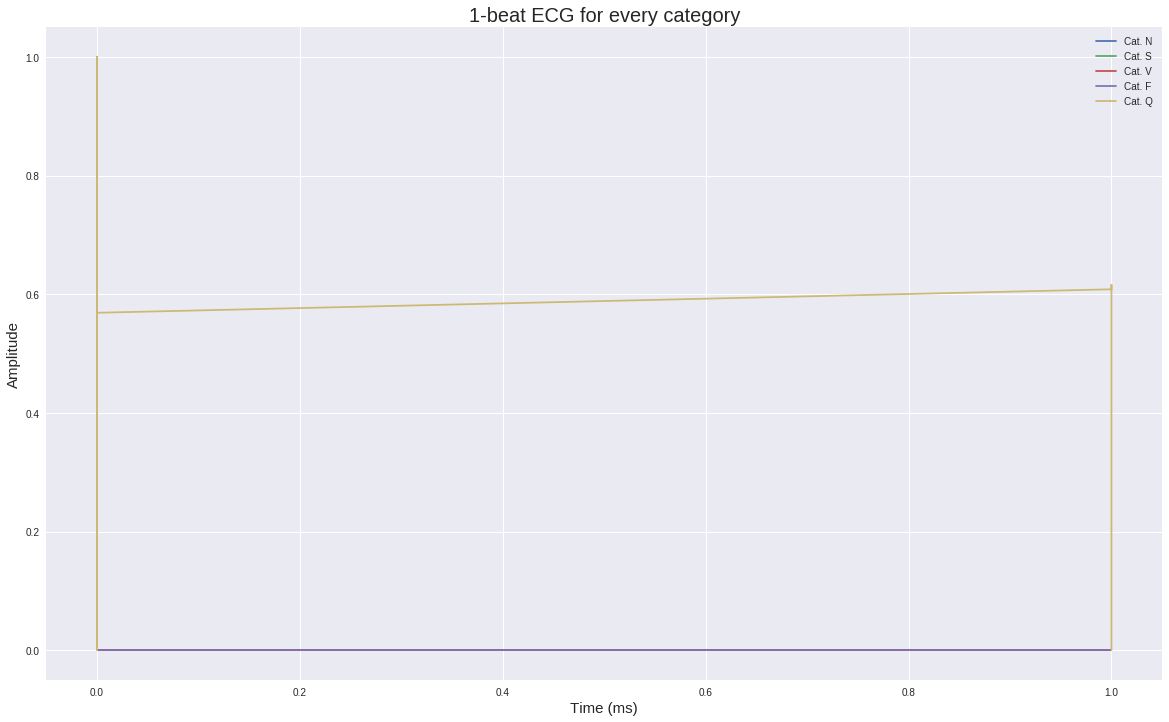

In [0]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

### Oversampling Data (Balancing the data)

In [0]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

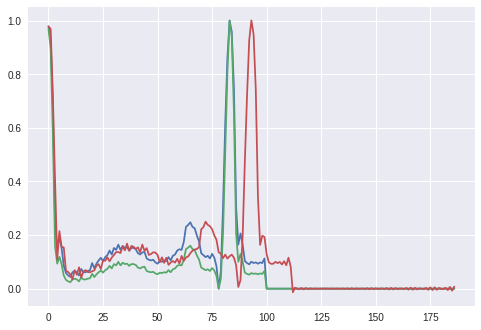

In [0]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [0]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

### Splitting Data 

In [0]:
## Splitting the data with selected features. Ratio 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


### Feature Scaling or Normalizing

In [0]:
# sc = StandardScaler()
# X = sc.fit_transform(X)

scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Feature Extraction With PCA

Notice the code below has .95 for the number of components parameter. It means that scikit-learn choose the minimum number of principal components such that 95% of the variance is retained.



In [0]:

# Make an instance of the Model
pca = PCA(.95)

# #fitting PCA on the training set only.
# pca.fit_transform(X)
# print(pca.n_components_)
# print (pca.explained_variance_ratio_)

## Apply transform to both the training set and the test set.
pca.fit(X_train)
print(pca.n_components_)
print (pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


41
[0.36532682 0.1562186  0.06702224 0.04799891 0.03351473 0.02478434
 0.02291246 0.01804447 0.01617267 0.01469133 0.01300534 0.01187791
 0.01148014 0.01104161 0.01013573 0.01005269 0.00940607 0.00894039
 0.00842866 0.00764936 0.00678203 0.00650278 0.00576714 0.00538515
 0.00501039 0.00466093 0.00445174 0.00421432 0.00394224 0.0038994
 0.00376435 0.00355841 0.00335847 0.00326597 0.00313794 0.00291132
 0.00271364 0.00258679 0.00244809 0.00236775 0.00228528]


### Implementing SVM

In [0]:
#svclassifier = svm.SVC(C=0.5, kernel='linear')  

# Create support vector classifier
svclassifier = SVC(kernel='poly', class_weight='balanced', C=1.0, random_state=0)


In [0]:

##WORKING 
#svclassifier = LinearSVC(class_weight='balanced', C=1.0, random_state=0, tol=1e-5)

n_estimators = 10
#svclassifier = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))


print("..................................Traning set................................")
svclassifier.fit(X_train, y_train)

print(svclassifier.predict(X_train))
score = svclassifier.score(X_train, y_train)
#print ("Training Set size = ", C)
print("Training Set accuracy = ", score*100)
print("Training Set error = ", (1-score)*100)



..................................Traning set................................


/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0 0 0 ... 0 0 0]
('Training Set accuracy = ', 96.2863102767237)
('Training Set error = ', 3.7136897232763033)


In [0]:

print("..................................Test set...................................")
#Get our result predictions 
y_pred = svclassifier.predict(X_test)
print(y_pred)
score = svclassifier.score(X_test, y_test)
#print("Test Set size = ",X.shape[0]-c)
print("Test Set accuracy = ", score*100)
print("Test Set error = ",(1-score)*100)


#Get our confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test,y_pred)
print(conf_mat)
print(class_report)

..................................Test set...................................
[0 0 3 ... 0 3 0]
('Test Set accuracy = ', 94.82513758210544)
('Test Set error = ', 5.174862417894555)
[[17345   428   133   298    43]
 [   66   456     9     5     2]
 [   49    23  1263    41     2]
 [   14     4    18   704     2]
 [   19     2     7     1  1598]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18247
           1       0.50      0.85      0.63       538
           2       0.88      0.92      0.90      1378
           3       0.67      0.95      0.79       742
           4       0.97      0.98      0.98      1627

   micro avg       0.95      0.95      0.95     22532
   macro avg       0.80      0.93      0.85     22532
weighted avg       0.96      0.95      0.95     22532



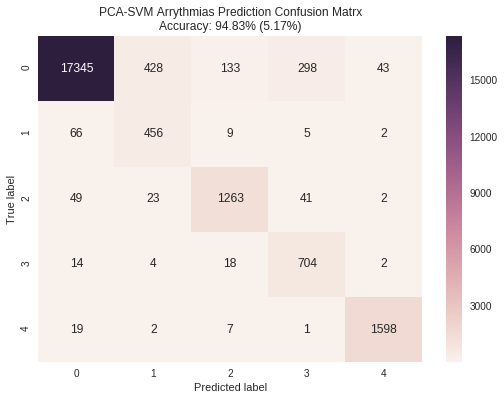

In [0]:
# Transform to df for easier plotting
cm_df = pd.DataFrame(conf_mat,
                     index = ['0','1','2','3','4'], 
                     columns = ['0','1','2','3','4'])

plt.figure(figsize=(8.6,6))
sns.heatmap(cm_df, annot=True,fmt='g')
#plt.title('Arrythmias Prediction Confusion Matrx With SVM')
plt.title('PCA-SVM Arrythmias Prediction Confusion Matrx\nAccuracy: %.2f%% (%.2f%%)' % (score*100, (1-score)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: [{} {} {}] '.format(round(accuracy, 2),sensitivity,round(specificity1, 2), round(specificity2, 2),round(specificity3, 2)), horizontalalignment='right')
plt.show()